<a href="https://colab.research.google.com/github/yashkens/course3-4-NLP/blob/master/hw5_collocations_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рекомендую открыть тетрадку в колабе,  чтобы удобно скрывать ненужные разделы  
Используется датасет категории Games 🎮

### Импорты и загрузки

In [1]:
!pip install allennlp==2.1.0 allennlp-models==2.1.0

     |████████████████████████████████| 585 kB 5.3 MB/s 
     |████████████████████████████████| 407 kB 38.8 MB/s 
     |████████████████████████████████| 131 kB 50.0 MB/s 
     |████████████████████████████████| 1.9 MB 33.0 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
     |████████████████████████████████| 12.8 MB 23.5 MB/s 
     |████████████████████████████████| 259 kB 53.4 MB/s 
     |████████████████████████████████| 1.2 MB 17.2 MB/s 
     |████████████████████████████████| 124 kB 55.3 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 8.4 MB 52.1 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 138 kB 50.2 MB/s 
     |████████████████████████████████| 127 kB 38.8 MB/s 
     |████████████████████████████████| 3.3 MB 36.1 MB/s 
     |████████████████████████████████| 895 kB 28.2 MB/s 
  Created wheel for 

In [2]:
!pip install transformers

In [3]:
!wget http://snap.stanford.edu/data/amazon/Video_Games.txt.gz

--2021-12-03 08:34:49--  http://snap.stanford.edu/data/amazon/Video_Games.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158584958 (151M) [application/x-gzip]
Saving to: ‘Video_Games.txt.gz’

Video_Games.txt.gz  100%[===================>] 151.24M  2.34MB/s    in 19s     

2021-12-03 08:35:08 (8.14 MB/s) - ‘Video_Games.txt.gz’ saved [158584958/158584958]



In [4]:
import gzip
import pandas as pd
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import random

from IPython.display import HTML, display_html

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import word_tokenize
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained("shtoshni/spanbert_coreference_large")
model = AutoModel.from_pretrained("shtoshni/spanbert_coreference_large")

Downloading:   0%|          | 0.00/521 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [6]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging

predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz", cuda_device=0)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Plugin allennlp_models could not be loaded: No module named 'nltk.translate.meteor_score'
downloading: 100%|##########| 1345986155/1345986155 [00:43<00:00, 31091910.26B/s]


Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Подготовка данных

In [12]:
def parse(filename):
  f = gzip.open(filename, 'r')
  entry = {}
  for l in f:
    l = l.strip().decode('utf-8')
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

json_list = []
for e in parse("/content/Video_Games.txt.gz"):
  json_list.append(e)

In [13]:
df = pd.DataFrame(json_list)

In [14]:
df = df.drop(['product/price', 'review/userId', 'review/profileName', 'review/helpfulness', 'review/time'], axis=1)
df = df.dropna()

In [15]:
df.head()

,product/productId,product/title,review/score,review/summary,review/text
0,B000068VBQ,Fisher-Price Rescue Heroes: Lava Landslide,2.0,Requires too much coordination,I bought this software for my 5 year old. He h...
1,B000068VBQ,Fisher-Price Rescue Heroes: Lava Landslide,2.0,You can't pick which parts you want to play!,I got this for my 4 year old son because he re...
2,B000068VBQ,Fisher-Price Rescue Heroes: Lava Landslide,1.0,Doesn't work on a Mac,It clearly says on line this will work on a Ma...
3,B000068VBQ,Fisher-Price Rescue Heroes: Lava Landslide,1.0,Very Frustrating,My three year old son was very excited to get ...
4,B000068VBQ,Fisher-Price Rescue Heroes: Lava Landslide,4.0,enjoyable,My almost four year old loves this game. It ca...


In [16]:
texts = df['review/text'].values

### 3 способа извлечь упоминания товаров

**1. Составить словарь по какой-либо базе данных**  
Например, можно было бы взять все синонимы и гипонимы слова *game* из WordNet. Но я посмотрела и не обнаружила там нужного значения этого слова.  
Могу предложить другие базы данных: [IGDB](https://www.igdb.com/api) (есть собственный API) или [WikiData](https://www.wikidata.org/wiki/Wikidata:WikiProject_Video_games/Lists/Genres). Также есть еще только зарождающаяся база [Glitchwave](https://glitchwave.com/games/genre/). Из них можно достать множество жанров игр, по пользователи могут отсылать к купленной игре.  
**Плюсы:** быстро - не нужно иметь много данных и долго вытаскивать из них entity. Также список жанров обещает быть полным, местами даже избыточным.  
**Есть минусы:** другие описательные названия игр вроде *CD, product, system*, program таким образом не отловятся. Также не получится таким образом собрать название техники, связанной с играми (а она есть в датасете), например *console, keyboard, headset*.


**2. Использовать контекстуальные эмбеддинги**  
Предполагается, что языковая модель, учитывающая контекст, дает близкие вектора словам, относящимся к одной и той же сущности. Так мы можем специально вставить необходимый нам гипероним к тексту (*game* или *product*), получить эмбеддинги всего текста. Затем вытащить вектор целевого слова и сравнивать его косинусную близость со всеми остальными словами. Слова с близостью выше некоторого порога - то, что нам нужно.  
**Плюсы:** найдутся сущности различных типов, включая все синонимы слова game, названия игр, техника, связанная с играми и т.д.  
**Минусы:**найдется слишком много сущностей, вкючая местоимения и глаголы, которые часто встречаются с целевым словом - но это легко фильтруется. Другой минус - сложно работать с н-граммами, то есть нужно приложить больше усилий, чтобы найти например н-грамм video game.

*Этот способ я начну реализовывать ниже и продемонстрирую плюсы и минусы.*

**3. Использовать инструмент для разрешения кореференции**  
Такие инструменты способны находить все упоминания той или иной сущности в тексте. Чтобы мы могли проконтроллировать, что нашлись упоминания нужной сущности, нужно добавить ее упоминание к началу текста самим. Я буду добавлять строку "I brought this product,".  
**Плюсы:** можно найти все типы сущностей, игры, их названия, игровую технику. Может брать н-граммы в качестве сущностей. Не нужно изобретать велосипед.  
**Минусы:** будут находится и местоимения, обозначающие сущность (но глаголы и т.п. как во 2 методе не будут). Иногда сущность может быть очень длинной, например, включать относительное придаточное.

*Этот способ я выберу для этой домашки и реализую его.*

### Реализация одного из способов

In [ ]:
device = 'cuda'
model = model.to(device)

In [ ]:
def get_embeddings(text):
  tokenized_text = tokenizer.tokenize(text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1]*len(indexed_tokens)

  tokens_tensor = torch.tensor([indexed_tokens], device=device)
  segments_tensors = torch.tensor([segments_ids], device=device)
  outputs = model(tokens_tensor, segments_tensors, output_hidden_states = True)
  hidden_states = outputs[2][1:]

  token_embeddings = hidden_states[-1]
  token_embeddings = torch.squeeze(token_embeddings, dim=0)
  embeddings = [token_embed.tolist() for token_embed in token_embeddings]
  return tokenized_text, embeddings

In [ ]:
# объединяет OOV токены и их эмбеддинги
def join_emb_by_token(tokens, embeds):
  new_tokens = []
  new_embeds = []
  i = 0
  j = 0
  while i < len(tokens):
    if tokens[i].startswith('##'):
      part = tokens[i][2:]
      new_embeds[j-1].append(embeds[i])
      new_tokens[j-1] += part
      i += 1
    else:
      new_tokens.append(tokens[i])
      new_embeds.append([embeds[i]])
      i += 1
      j += 1
  for i, emb in enumerate(new_embeds):
    new_embeds[i] = np.mean(emb, axis=0)
  return new_tokens, new_embeds

#### SpanBert
Идея: с помощью контекстуальных эмбеддингов найти токены, которые наиболее близки (по косинусной близости) к слову game.   
Эмбеддинг слова game также беру из контекста (добавляю это слово в виде строки "About the game:" к тексту).  
Для получения эбеддингов выбрала SpanBert, потому что это дообученный Bert в том числе для задачи coreference resolution.

In [ ]:
def get_token_weights(text):
  text = 'About the game:' + text
  tokens, embs = get_embeddings(text)
  tokens, embs = join_emb_by_token(tokens, embs)
  target_emb = embs[2]
  left_tokens = tokens[4:]
  similarities = cosine_similarity(target_emb.reshape(1, -1), embs[4:])[0]

  # изменим значения близостей для лучшего отображения на картинке
  similarities = similarities**10
  similarities -= similarities.min()
  similarities /= similarities.max()
  return left_tokens, similarities

In [ ]:
def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(0.5 - weight/2, bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

**Пример 1**  
Видим, что выделяются слова *software, game, games, it*. По контексту понятно, что все этим слова действительно отсылают к товару.
Есть и лишние слова - артикли *the* и местоимение *this* можно отсеять по части речи, но *exercise* нет.

In [ ]:
tokens, weights = get_token_weights(texts[0])
tokens_and_weights = list(zip(tokens, weights))

In [ ]:
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:14px;');

I bought this software for my 5 year old . He has a couple of the other RH software games and he likes them a lot . This game , however , was too challenging for him . The biggest problem I see is that the game requires the child to be able to maneuver the vehicle using all 4 scroll keys on the keyboard . During one exercise , which by the way you can ' t get to the next level until you complete this exercise , the game requires that you use the keys to move while watching out for falling lava rocks and clouds , monitor a fuel gauge , watch arrow indicators that help you determine where objects are in the arena below , and watch a scope that shows animals when you ' re hovering over the top of them . I tried to perform this exercise myself and got frustrated . It ' s just too hard to expect even a 7 year old to complete this exercise let alone a 5 year old . There are some exercises he can complete himself but they mostly require using the left , right keys . I don ' t know who this game would be good for . Parts of it would be too easy for someone 7 or older . Yet some parts are too difficult for those younger than that .

**Пример 2**  
Здесь товар упоминается как *CD*. В первом случае наш метод обнаруживает это упоминание, а во второй - нет. Зато находится много лишнего, как *girls, creativity, played*.

In [ ]:
tokens, weights = get_token_weights(texts[12])
tokens_and_weights = list(zip(tokens, weights))

In [ ]:
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:14px;');

My four - year - old loved this CD . She played it over and over until she exhausted the CD about 10 times . She was able to play it by herself . It is cleverly designed with games that utilize a child ' s creativity . I highly recommend it for young girls .

In [ ]:
def get_game_similar(text):
  text = 'About the game:' + text
  tokens, embs = get_embeddings(text)
  tokens, embs = join_emb_by_token(tokens, embs)
  target_emb = embs[2]
  left_tokens = tokens[4:]
  similarities = cosine_similarity(target_emb.reshape(1, -1), embs[4:])[0]
  non_zero_sim = similarities[similarities >= 0.5]
  non_zero_tok = np.array(left_tokens)[similarities >= 0.5]
  inds = np.argsort(non_zero_sim)[::-1]
  words = np.array(non_zero_tok)[inds]
  filtered_words = [word for word in words if word.isalpha() and word != 'game' and word != 'games']
  return filtered_words

**Попробуем собрать самые все слова**  
Текстов больше 400 тыс. Чтобы не терять времени, соберу слова только из 10 тыс.   
Лишних слов получилось действительно много, но многие из них можно отсеять фильтром по частям речи. Например, можно было бы оставить только существительные.   
Главный минус этого подхода - он не находит н-граммы. Это следующий этап улучшения. Можно было бы объединять в н-граммы все слова, находящиеся рядом и превышающие порог косинусной близости. 
Но я не хочу изобретать велосипед, поэтому воспользуюсь готовым иструментом от AllenAI. 😉

In [ ]:
game_words = []
for text in tqdm(texts[:10000]):
  try:
    words = get_game_similar(text)
    game_words.extend(words)
  except:
    pass

100%|██████████| 10000/10000 [21:17<00:00,  7.83it/s]


In [ ]:
Counter(game_words).most_common(15)

[('it', 9316),
 ('this', 8197),
 ('I', 6680),
 ('the', 4687),
 ('This', 2836),
 ('It', 2089),
 ('The', 923),
 ('one', 750),
 ('i', 576),
 ('you', 439),
 ('me', 415),
 ('they', 348),
 ('its', 314),
 ('my', 312),
 ('version', 296)]

* Есть слова, которые действительно отсылают к товару: product, program, software, system, CD, RPG и названия игр (Diablo, Kombat, Vexx)
* Некоторые слова показывают необходимость н-грамм: video (game), adventure (game)
* Самые частотные слова тоже отсылают к товарам, но они нам не нужны и их нужно отсеять через стоп-слова или фильтры частей речи: it, this. (часть из них я убрала стоп-словами, а часть осталась из-за заглавной буквы)
* Уже на этом этапе можно отследить, как покупатели характеризуют товар: fun, great, new

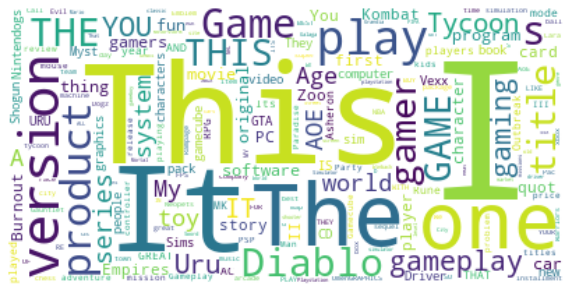

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white")
freq = {a: b for a, b in Counter(game_words).items() if a not in stopwords}
wordcloud.generate_from_frequencies(frequencies=freq)
plt.figure(figsize=(10, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Allen AI Coreference Resolution

In [ ]:
def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(weight, bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

In [ ]:
def find_game_words_ext(text):
  text = 'I brought this product, ' + text
  res = predictor.predict(document=text)
  cluster_words = []
  cluster_ngrams = []
  for cluster in res['clusters']:
    words = []
    words_ngram = []
    for item in cluster:
      words.extend(res['document'][item[0]: item[1]+1])
      words_ngram.append(' '.join(res['document'][item[0]: item[1]+1]).lower())
    cluster_words.append(words)
    cluster_ngrams.append(words_ngram)

  for i, ngrams in enumerate(cluster_ngrams):
    if 'this product' in ngrams:
      index = i
      break
  cluster = [item for sublist in res['clusters'][i] for item in sublist]
  return cluster, cluster_ngrams[i], res['document']

**Пример 1**

In [ ]:
cluster, ngrams, tokens = find_game_words_ext(texts[0])

weights = [0.5] * len(tokens)
weights = np.array(weights)
weights[cluster] = 0.3

In [ ]:
tokens_and_weights = list(zip(tokens, weights))
draw_html([(tok, weight) for tok, weight in tokens_and_weights], font_style='font-size:14px;');

I brought this product , I bought this software for my 5 year old . He has a couple of the other RH software games and he likes them a lot . This game , however , was too challenging for him . The biggest problem I see is that the game requires the child to be able to maneuver the vehicle using all 4 scroll keys on the keyboard . During one exercise , which by the way you ca n't get to the next level until you complete this exercise , the game requires that you use the keys to move while watching out for falling lava rocks and clouds , monitor a fuel gauge , watch arrow indicators that help you determine where objects are in the arena below , and watch a scope that shows animals when you 're hovering over the top of them . I tried to perform this exercise myself and got frustrated . It 's just too hard to expect even a 7 year old to complete this exercise let alone a 5 year old . There are some exercises he can complete himself but they mostly require using the left , right keys . I do n't know who this game would be good for . Parts of it would be too easy for someone 7 or older . Yet some parts are too difficult for those younger than that .

**Пример 2**

In [ ]:
cluster, ngrams, tokens = find_game_words_ext(texts[12])

weights = [0.5] * len(tokens)
weights = np.array(weights)
weights[cluster] = 0.3

In [ ]:
tokens_and_weights = list(zip(tokens, weights))
draw_html([(tok, weight) for tok, weight in tokens_and_weights], font_style='font-size:14px;');

I brought this product , My four - year - old loved this CD . She played it over and over until she exhausted the CD about 10 times . She was able to play it by herself . It is cleverly designed with games that utilize a child 's creativity . I highly recommend it for young girls .

**Размечаем все**

In [ ]:
def find_game_words(text):
  text = 'I brought this product, ' + text
  res = predictor.predict(document=text)
  cluster_ngrams = []
  for cluster in res['clusters']:
    words_ngram = []
    for item in cluster:
      words_ngram.append(' '.join(res['document'][item[0]: item[1]+1]).lower())
    cluster_ngrams.append(words_ngram)

  index = -1
  for i, ngrams in enumerate(cluster_ngrams):
    if 'this product' in ngrams:
      index = i
      break
  if index != -1:
    return cluster_ngrams[index]
  else:
    return []

In [ ]:
random.shuffle(texts)

In [ ]:
game_words = []

In [ ]:
for i in tqdm(range(30000, 40000)):
  if len(texts[i]) > 4000:
    continue
  game_words.extend(find_game_words(texts[i]))

100%|█████████▉| 9996/10000 [57:00<00:00,  6.64it/s]

In [ ]:
# with open('game_words.txt', 'w', encoding='utf-8') as f:
#   f.write('\n'.join(game_words))

#### Посмотрим, что получилось
Я загружаю из файла, потому что колаб сыграл со мной злую шутку и сломался спустя 3+ часа обработки. Второй раз уже сохраняла в файл...

In [7]:
with open('game_words.txt', 'r', encoding='utf-8') as f:
  text = f.read()
game_words = text.split('\n')

In [ ]:
# 15 most common
Counter(game_words).most_common(15)

[('it', 50995),
 ('this product', 30974),
 ('this game', 29581),
 ('the game', 17301),
 ('this', 13131),
 ('its', 3871),
 ('this one', 2043),
 ("it 's", 443),
 ('itself', 373),
 ('they', 327),
 ("the game 's", 314),
 ('the game itself', 283),
 ('the product', 277),
 ('this controller', 263),
 ('this title', 253)]

In [ ]:
# 15 least common
Counter(game_words).most_common()[:-15:-1]

[('sargeant rico', 1),
 ("republic 's", 1),
 ('" elf bowling "', 1),
 ('this zboard', 1),
 ('the dora the explorer animal adventures game', 1),
 ('this good of a game!it', 1),
 ('not so great game', 1),
 ('imho', 1),
 ('bof', 1),
 ('this sweet bmx title', 1),
 ('this hype game', 1),
 ('this latest installment in the metal gear series', 1),
 ('well done masterpiece of a game', 1),
 ('lousy game .', 1)]

In [9]:
def filter_product_names(product_names):
  banned_pos = ['DT', 'PRP', 'PRP$', 'DT$']
  filtered = []
  for name in product_names:
    res = nltk.pos_tag(word_tokenize(name))
    final = [pair for pair in res if pair[1] not in banned_pos]
    if " 's" in name:
      final = []
    if final:
      filtered.append(name)
  return filtered

In [10]:
c = Counter(game_words).most_common()
print(f'Количество найденных названий: {len(c)}')
product_names = [pair[0] for pair in c if pair[1] >= 30]
product_names = filter_product_names(product_names)
print(f'Количество названий после фильтров: {len(product_names)}')

Количество найденных названий: 7721
Количество названий после фильтров: 88


In [ ]:
product_names[:10]

['this product',
 'this game',
 'the game',
 'this one',
 'the game itself',
 'the product',
 'this controller',
 'this title',
 'this thing',
 'this item']

## Выделение коллокаций

#### Считаем то, что пригодится для всех коллокаций

In [17]:
tokenized_texts = []
for text in tqdm(texts):
  tokenized_texts.append(word_tokenize(text))

100%|██████████| 463669/463669 [09:17<00:00, 831.05it/s]


In [18]:
vectorizer = CountVectorizer()
count_vecs = vectorizer.fit_transform(texts)
features = vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
lens = [len(tokens) for tokens in tokenized_texts]
all_words_in_corpus = sum(lens)

#### Функция для выделения коллокаций

In [20]:
def find_ngrams(product_name):
  curr_name = product_name.split()
  before_words = []
  after_words = []
  curr_name_count = 0
  for tokens in tqdm(tokenized_texts):
    for i in range(len(tokens)-len(curr_name)+1):
      if tokens[i:i+len(curr_name)] == curr_name:
        if i > 0 and tokens[i-1].isalpha():
          before_words.append(tokens[i-1])
        if i+len(curr_name) < len(tokens) and tokens[i+len(curr_name)].isalpha():
          after_words.append(tokens[i+len(curr_name)])
        curr_name_count += 1
  return before_words, after_words, curr_name_count

In [ ]:
before_grams, after_grams, curr_name_count = find_ngrams('this product')

100%|██████████| 463669/463669 [00:18<00:00, 25085.62it/s]


In [ ]:
Counter(before_words).most_common(15)

[('recommend', 788),
 ('with', 664),
 ('of', 514),
 ('buy', 413),
 ('bought', 343),
 ('for', 336),
 ('about', 280),
 ('on', 225),
 ('purchased', 194),
 ('buying', 179),
 ('that', 170),
 ('give', 104),
 ('ordered', 93),
 ('purchasing', 92),
 ('to', 90)]

In [ ]:
Counter(after_words).most_common(15)

[('is', 710),
 ('to', 481),
 ('and', 381),
 ('for', 377),
 ('was', 184),
 ('because', 144),
 ('as', 109),
 ('if', 104),
 ('a', 92),
 ('at', 86),
 ('on', 76),
 ('will', 74),
 ('does', 73),
 ('in', 71),
 ('I', 68)]

#### PMI

In [21]:
def count_w2_P(word, ind):
  p = count_vecs[:,ind].sum()/all_words_in_corpus
  return p

In [30]:
def count_PMI(gram_word, together_c, curr_name_count):
  if gram_word.lower() not in features:
    return -np.inf
  ind = features.index(gram_word.lower())
  up = together_c/all_words_in_corpus
  down = count_w2_P(gram_word, ind)*curr_name_count/all_words_in_corpus
  return np.log2(up/down)

In [23]:
main_colloc = product_names[0]
print(f'Название продукта: {main_colloc}')
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
# берем только 30 самых частотных слов
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
b_pmis = []
a_pmis = []
for gram_word in tqdm(cut_b_words):
  pmi = count_PMI(gram_word, before_grams.count(gram_word), curr_name_count)
  b_pmis.append(pmi)
for gram_word in tqdm(cut_a_words):
  pmi = count_PMI(gram_word, after_grams.count(gram_word), curr_name_count)
  a_pmis.append(pmi)

Название продукта: this product


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


In [ ]:
sorted_b_words = np.array(cut_b_words)[np.argsort(b_pmis)][::-1]
sorted_a_words = np.array(cut_a_words)[np.argsort(a_pmis)][::-1]
print(f'Название продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

Название продукта: this product
-----
purchasing this product
recommend this product
ordered this product
purchased this product
recomend this product
-----
this product unless
this product works
this product came
this product does
this product because


In [ ]:
main_colloc = 'the wii'
print(f'Название продукта: {main_colloc}')
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
# берем только 30 самых частотных слов
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
b_pmis = []
a_pmis = []
for gram_word in tqdm(cut_b_words):
  pmi = count_PMI(gram_word, before_grams.count(gram_word), curr_name_count)
  b_pmis.append(pmi)
for gram_word in tqdm(cut_a_words):
  pmi = count_PMI(gram_word, after_grams.count(gram_word), curr_name_count)
  a_pmis.append(pmi)

Название продукта: the wii


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


In [ ]:
sorted_b_words = np.array(cut_b_words)[np.argsort(b_pmis)][::-1]
sorted_a_words = np.array(cut_a_words)[np.argsort(a_pmis)][::-1]
print(f'Название продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

Название продукта: the wii
-----
using the wii
use the wii
on the wii
with the wii
bought the wii
-----
the wii mote
the wii zapper
the wii remote
the wii remotes
the wii shop


#### t-score

In [31]:
def count_T_score(gram_word, together_c, curr_name_count):
  if gram_word.lower() not in features:
    return -np.inf
  ind = features.index(gram_word.lower())
  up = together_c/all_words_in_corpus - count_w2_P(gram_word, ind)*curr_name_count/all_words_in_corpus
  down = (together_c/all_words_in_corpus)**0.5
  return up/down

In [ ]:
main_colloc = product_names[0]
print(f'Название продукта: {main_colloc}')
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
# берем только 30 самых частотных слов
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
b_scores = []
a_scores = []
for gram_word in tqdm(cut_b_words):
  score = count_T_score(gram_word, before_grams.count(gram_word), curr_name_count)
  b_scores.append(score)
for gram_word in tqdm(cut_a_words):
  score = count_T_score(gram_word, after_grams.count(gram_word), curr_name_count)
  a_scores.append(score)

Название продукта: this product


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


In [ ]:
sorted_b_words = np.array(cut_b_words)[np.argsort(b_pmis)][::-1]
sorted_a_words = np.array(cut_a_words)[np.argsort(a_pmis)][::-1]
print(f'Название продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

Название продукта: this product
-----
buying this product
bought this product
with this product
of this product
like this product
-----
this product because
this product it
this product is
this product in
this product came


#### Jaccard

In [ ]:
def count_jaccard(gram_word, together_c, curr_name_count):
  if gram_word.lower() not in features:
    return -np.inf
  ind = features.index(gram_word.lower())
  up = together_c
  down = count_vecs[:,ind].sum() + curr_name_count - together_c
  return up/down

In [ ]:
main_colloc = product_names[0]
print(f'Название продукта: {main_colloc}')
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
# берем только 30 самых частотных слов
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
b_scores = []
a_scores = []
for gram_word in tqdm(cut_b_words):
  score = count_jaccard(gram_word, before_grams.count(gram_word), curr_name_count)
  b_scores.append(score)
for gram_word in tqdm(cut_a_words):
  score = count_jaccard(gram_word, after_grams.count(gram_word), curr_name_count)
  a_scores.append(score)

Название продукта: this product


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


In [ ]:
sorted_b_words = np.array(cut_b_words)[np.argsort(b_pmis)][::-1]
sorted_a_words = np.array(cut_a_words)[np.argsort(a_pmis)][::-1]
print(f'Название продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

Название продукта: this product
-----
buying this product
bought this product
with this product
of this product
like this product
-----
this product because
this product it
this product is
this product in
this product came


## 5 примеров и итог

Я попробовала все 3 метрики на 3-5 примерах. Я решила, что PMI выдает больше релевантных для нас коллокаций, поэтому я буду использовать ее далее.
T-score и Jaccard ставят выше по рангу особо частотные слова, но это не всегда лучше.

Предлагаю посмотреть на следующие названия продуктов:
* Разные названия игр: собственно **the game**, **this product** уже видели выше и какое-нибудь конкретное название игры - **halo**.
* Товары, связанные с играми: **this controller, this headset, this keyboard, this mouse**
* Различные консоли: **the wii** (этот пример выше), **the psp**

Хуже всего почему-то коллокации выделяются для консолей. В топ-30 н-грамм с ними в принципе входит мало осмысленных слов.

In [32]:
def rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count):
  b_scores = []
  a_scores = []
  for gram_word in tqdm(cut_b_words):
    score = count_PMI(gram_word, before_grams.count(gram_word), curr_name_count)
    b_scores.append(score)
  for gram_word in tqdm(cut_a_words):
    score = count_PMI(gram_word, after_grams.count(gram_word), curr_name_count)
    a_scores.append(score)
  sorted_b_words = np.array(cut_b_words)[np.argsort(b_pmis)][::-1]
  sorted_a_words = np.array(cut_a_words)[np.argsort(a_pmis)][::-1]
  return sorted_b_words, sorted_a_words

In [ ]:
main_colloc = product_names[1]
print(f'Название продукта: {main_colloc}')
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
sorted_b_words, sorted_a_words = rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count)

print(f'Название продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

Название продукта: this game


100%|██████████| 30/30 [00:08<00:00,  3.69it/s]

Название продукта: this game
-----
that this game
love this game
of this game
about this game
but this game
-----
this game has
this game but
this game is
this game if
this game that


In [ ]:
main_colloc = product_names[6]
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
sorted_b_words, sorted_a_words = rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count)

print(f'Название продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

100%|██████████| 30/30 [00:07<00:00,  4.04it/s]

Название продукта: this controller
-----
using this controller
recommend this controller
bought this controller
of this controller
to this controller
-----
this controller was
this controller on
this controller is
this controller so
this controller at


In [49]:
main_colloc = product_names[17]
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
sorted_b_words, sorted_a_words = rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count)

print(f'\nНазвание продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


Название продукта: the psp
-----
then the psp
for the psp
as the psp
about the psp
is the psp
-----
the psp at
the psp as
the psp are
the psp so
the psp for


In [52]:
print('Все слова для the psp')
print(sorted_b_words)
print(sorted_a_words)

Все слова для the psp
['then' 'for' 'as' 'about' 'is' 'have' 'from' 'get' 'of' 'when' 'that'
 'play' 'in' 'and' 'on' 'think' 'what' 'holding' 'with' 'than' 'protect'
 'to' 'buy' 'put' 'but' 'bought' 'over' 'got' 'like' 'while']
['at' 'as' 'are' 'so' 'for' 'that' 'a' 'but' 'is' 'version' 'in' 'screen'
 'out' 'to' 'while' 'system' 'and' 'can' 'itself' 'or' 'has' 'was' 'i'
 'if' 'with' 'games' 'because' 'the' 'it' 'will']


In [34]:
main_colloc = product_names[14]
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
sorted_b_words, sorted_a_words = rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count)

print(f'\nНазвание продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

100%|██████████| 30/30 [00:09<00:00,  3.30it/s]


Название продукта: halo
-----
with halo
like halo
played halo
to halo
but halo
-----
halo i
halo where
halo one
halo killer
halo for


In [ ]:
main_colloc = product_names[43]
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
sorted_b_words, sorted_a_words = rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count)

print(f'\nНазвание продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

100%|██████████| 30/30 [00:07<00:00,  3.87it/s]


Название продукта: this keyboard
-----
purchased this keyboard
of this keyboard
bought this keyboard
love this keyboard
buying this keyboard
-----
this keyboard was
this keyboard with
this keyboard is
this keyboard does
this keyboard looks


In [ ]:
main_colloc = product_names[29]
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
sorted_b_words, sorted_a_words = rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count)

print(f'\nНазвание продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Название продукта: this headset
-----
got this headset
about this headset
with this headset
of this headset
used this headset
-----
this headset was
this headset would
this headset is
this headset when
this headset if


In [ ]:
main_colloc = product_names[42]
before_grams, after_grams, curr_name_count = find_ngrams(main_colloc)
cut_b_words = [pair[0] for pair in Counter(before_grams).most_common(30)]
cut_a_words = [pair[0] for pair in Counter(after_grams).most_common(30)]
sorted_b_words, sorted_a_words = rank_by_PMI(cut_b_words, cut_a_words, before_grams, after_grams, curr_name_count)

print(f'\nНазвание продукта: {main_colloc}\n-----')
for word in list(sorted_b_words)[:5]:
  print(word, main_colloc)
print('-----')
for word in list(sorted_a_words)[:5]:
  print(main_colloc, word)

100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


Название продукта: this mouse
-----
for this mouse
love this mouse
bought this mouse
of this mouse
owned this mouse
-----
this mouse has
this mouse so
this mouse is
this mouse on
this mouse just
